# Description of the notebook

Students:
- Teka Kimbi Ntimanputu (10673197)
- William Stucchi (10661711)
- Lorenzo Veronese (10654901)

This notebook is contains one of the models described in Section III of the report, regarding specifically category A.

# Connection to Google Drive and some parameters

In [ ]:
RESTORE_DATASET = True  # set this flag to true if you need to generate the dataset with no padding for the series
PATH_TO_DRIVE = '/content/gdrive/My Drive/Colab Notebooks/ANNDL/Homework 2' # where to store the modified dataset
MAX_PRINT = 10  # number of time series to print (to wait seconds instead of hours for the printing function)

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Colab Notebooks/ANNDL/Homework 2

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/ANNDL/Homework 2


# Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
import shutil
import zipfile
from zipfile import ZipFile

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', size=16)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
import pandas as pd
from scipy.signal import correlate
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

# Inspect dataset

In [ ]:
if RESTORE_DATASET:
  # Replace 'your_file.zip' with the actual name of your zip file
  zip_file_name = 'training_dataset.zip'

  # Read the zip file
  with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
      # Extract all the contents to a folder (you can change the destination folder)
      zip_ref.extractall('/content/dataset')
else:
  # Replace 'your_file.zip' with the actual name of your zip file
  zip_file_name = 'training_dataset_no_padding.zip'

  # Read the zip file
  with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
      # Extract all the contents to a folder (you can change the destination folder)
      zip_ref.extractall('/content/dataset_nopadding')

In [ ]:
if RESTORE_DATASET:
  categories = np.load('/content/dataset/categories.npy', allow_pickle=True)
else:
  categories = np.load('/content/dataset_nopadding/categories.npy', allow_pickle=True)

print(categories)

['D' 'D' 'D' ... 'F' 'F' 'F']


In [ ]:
if RESTORE_DATASET:
  valid_periods = np.load('/content/dataset/valid_periods.npy', allow_pickle=True)
else:
  valid_periods = np.load('/content/dataset_nopadding/valid_periods.npy', allow_pickle=True)

print(valid_periods)

[[2325 2776]
 [2325 2776]
 [2325 2776]
 ...
 [2676 2776]
 [2676 2776]
 [2676 2776]]


In [ ]:
if RESTORE_DATASET:
  training_data = np.load('/content/dataset/training_data.npy', allow_pickle=True)

  # remove padding from the original dataset
  training_data_no_padding = []
  for (training_datum, valid_period) in zip(training_data, valid_periods):
      training_data_no_padding.append(training_datum[valid_period[0] : valid_period[1]])
  training_data_no_padding = [np.array(inner_list, dtype=np.float32) for inner_list in training_data_no_padding]

else:
  training_data_no_padding = np.load('/content/dataset_nopadding/training_data_no_padding.npy', allow_pickle=True)

print(training_data_no_padding)

[array([0.49166667, 0.5240741 , 0.54444444, 0.46388888, 0.40648147,
        0.35462964, 0.31296295, 0.36666667, 0.38333333, 0.27962962,
        0.23796296, 0.2574074 , 0.47962964, 0.4324074 , 0.53518516,
        0.48055556, 0.37592593, 0.3861111 , 0.32685184, 0.36666667,
        0.25555557, 0.23981482, 0.21111111, 0.26481482, 0.46851853,
        0.46944445, 0.41666666, 0.4398148 , 0.3611111 , 0.32592592,
        0.3074074 , 0.3425926 , 0.28611112, 0.2787037 , 0.18425927,
        0.21111111, 0.38518518, 0.375     , 0.44444445, 0.32962963,
        0.38981482, 0.29444444, 0.27037036, 0.3351852 , 0.31666666,
        0.3148148 , 0.2888889 , 0.31203705, 0.39444444, 0.475     ,
        0.51666665, 0.47685185, 0.47777778, 0.37222221, 0.32685184,
        0.43888888, 0.35833332, 0.40648147, 0.36944443, 0.38981482,
        0.5546296 , 0.53333336, 0.5537037 , 0.53518516, 0.48333332,
        0.5046296 , 0.42777777, 0.4787037 , 0.46666667, 0.42962962,
        0.43888888, 0.41296297, 0.55833334, 0.52

In [ ]:
# check data normalization
for i in range(0, len(training_data_no_padding)):
  print(np.max(training_data_no_padding[i]) if np.max(training_data_no_padding[i]) > 1 else '')
  print(np.max(training_data_no_padding[i]) if np.max(training_data_no_padding[i]) < 0 else '')

Output streaming troncato alle ultime 5000 righe.
























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































In [ ]:
# save dataset with no padding
if RESTORE_DATASET:
  # Create a folder to store the arrays
  folder_path = '/content/gdrive/My Drive/Colab Notebooks/ANNDL/Homework 2/dataset_nopadding'
  os.makedirs(folder_path, exist_ok=True)

  # Save the arrays to the folder
  np.save(os.path.join(folder_path, 'categories.npy'), categories)
  np.save(os.path.join(folder_path, 'training_data_no_padding.npy'), training_data_no_padding)
  np.save(os.path.join(folder_path, 'valid_periods.npy'), valid_periods)

  # Create a zip file
  zip_filename = '/content/gdrive/My Drive/Colab Notebooks/ANNDL/Homework 2/training_dataset_no_padding.zip'
  with ZipFile(zip_filename, 'w') as zipf:
      # Add the contents of the folder to the zip file
      for root, dirs, files in os.walk(folder_path):
          for file in files:
              file_path = os.path.join(root, file)
              arcname = os.path.relpath(file_path, folder_path)
              zipf.write(file_path, arcname=arcname)

  # Optionally, remove the folder with the saved arrays
  shutil.rmtree(folder_path)

  print(f'Arrays saved and zipped in "{zip_filename}"')

In [ ]:
# check if the length of the training data without padding is correct
def check_length(data = training_data_no_padding, valid_periods = valid_periods):
  check_len = 0
  indexes = []

  for i in range(0, len(training_data_no_padding)):
    if len(training_data_no_padding[i]) != (valid_periods[i][1] - valid_periods[i][0]):
      check_len = check_len + 1
      indexes.append(i)

  print("Wrong padding in " + str(check_len) + " timeseries")
  if check_len > 0:
    print("Indexes of wrong timeseries: ")
    print(indexes)

check_length(training_data_no_padding, valid_periods)

Wrong padding in 0 timeseries


# Plot the timeseries

In [ ]:
def plot_timeseries(data=training_data_no_padding, sel_category='A', categories=categories):
    stop = 0
    for i, (series, category) in enumerate(zip(data, categories)):
        if(category == sel_category):
          print(len(series))
          plt.figure(figsize=(50, 10))
          plt.plot(data[i], label='Time Series Data')
          plt.title('Time Series Plot')
          plt.xlabel('Index')
          plt.ylabel('Data Values')
          plt.legend()

          plt.show()

          stop += 1
          if(stop==MAX_PRINT): break

## Cat A

In [ ]:
plot_timeseries(sel_category='A')

"plot_timeseries(sel_category='A')"

## Cat B

In [ ]:
plot_timeseries(sel_category='B')

"plot_timeseries(sel_category='B')"

## Cat C

In [ ]:
plot_timeseries(sel_category='C')

"plot_timeseries(sel_category='C')"

## Cat D

In [ ]:
plot_timeseries(sel_category='D')

"plot_timeseries(sel_category='D')"

## Cat E

In [ ]:
plot_timeseries(sel_category='E')

"plot_timeseries(sel_category='E')"

## Cat F

In [ ]:
plot_timeseries(sel_category='F')

"plot_timeseries(sel_category='F')"

# Preparing the windows

Create data structures useful for the subsequent steps and create a version of the dataset where all time series of each category are separated from the others:

In [ ]:
categories_names, counts = np.unique(categories, return_counts=True)
dataset_by_categories = [[], [], [], [], [], []]
index_to_category = {
    0 : 'A',
    1 : 'B',
    2 : 'C',
    3 : 'D',
    4 : 'E',
    5 : 'F'
}
category_to_index = {
    'A' : 0,
    'B' : 1,
    'C' : 2,
    'D' : 3,
    'E' : 4,
    'F' : 5
}

# divide dataset in categories
for i, (data, category) in enumerate(zip(training_data_no_padding, categories)):
    dataset_by_categories[category_to_index[category]].append(data)

dataset_by_categories = np.array(dataset_by_categories)
dataset_by_categories[0][0]

array([0.3560538 , 0.25650224, 0.29596412, 0.26816145, 0.20896861,
       0.29506725, 0.30403587, 0.25650224, 0.2852018 , 0.23049328,
       0.21883409, 0.21704036, 0.21255605, 0.2116592 , 0.22511211,
       0.1632287 , 0.1748879 , 0.14439462, 0.22690582, 0.18565023,
       0.12376682, 0.18744394, 0.17757848, 0.19910313, 0.18475336,
       0.22600897, 0.22242153, 0.17937219, 0.13363229, 0.18923767,
       0.19730942, 0.19013453, 0.16860987, 0.15336323, 0.12825112,
       0.11748879, 0.17399102, 0.14439462, 0.13721973, 0.15784754,
       0.12107623, 0.13452914, 0.09686099, 0.09686099, 0.11210762,
       0.08878924, 0.1147982 , 0.12735426, 0.15336323, 0.14170404,
       0.12556054, 0.1264574 , 0.05829597, 0.09686099, 0.15336323,
       0.0690583 , 0.10224215, 0.11659193, 0.09596413, 0.13901345,
       0.1219731 , 0.06098655, 0.08251121, 0.03766816, 0.04753363,
       0.01524664, 0.07802691, 0.05560538, 0.07713004, 0.06098655,
       0.06188341, 0.0573991 , 0.02959641, 0.0573991 , 0.04932

In [ ]:
dataset_by_categories.shape

catA = dataset_by_categories[0]
print(len(catA))
print(catA[0])

5728
[0.3560538  0.25650224 0.29596412 0.26816145 0.20896861 0.29506725
 0.30403587 0.25650224 0.2852018  0.23049328 0.21883409 0.21704036
 0.21255605 0.2116592  0.22511211 0.1632287  0.1748879  0.14439462
 0.22690582 0.18565023 0.12376682 0.18744394 0.17757848 0.19910313
 0.18475336 0.22600897 0.22242153 0.17937219 0.13363229 0.18923767
 0.19730942 0.19013453 0.16860987 0.15336323 0.12825112 0.11748879
 0.17399102 0.14439462 0.13721973 0.15784754 0.12107623 0.13452914
 0.09686099 0.09686099 0.11210762 0.08878924 0.1147982  0.12735426
 0.15336323 0.14170404 0.12556054 0.1264574  0.05829597 0.09686099
 0.15336323 0.0690583  0.10224215 0.11659193 0.09596413 0.13901345
 0.1219731  0.06098655 0.08251121 0.03766816 0.04753363 0.01524664
 0.07802691 0.05560538 0.07713004 0.06098655 0.06188341 0.0573991
 0.02959641 0.0573991  0.04932735 0.1147982  0.0690583  0.09506726
 0.05650224 0.         0.04484305 0.02600897 0.02959641 0.05919283
 0.08789238 0.07533632 0.1309417  0.1309417  0.11210762 0.

Shuffle the the time series contained inside each category list:

In [ ]:
np.random.seed(42)

np.random.shuffle(catA)
print(catA[0])

[0.09083416 0.11135604 0.11138821 0.09512629 0.08606377 0.07637145
 0.07420266 0.0756048  0.09573994 0.08537591 0.07476568 0.04915958
 0.06078921 0.08370345 0.07865696 0.07128735 0.06438264 0.0576733
 0.05626497 0.07262265 0.06024503 0.05874837 0.05553907 0.04201939
 0.04707289 0.05678718 0.03323365 0.0280992  0.03061388 0.0334106
 0.01862821 0.03345053 0.02059251 0.03819083 0.02437792 0.
 0.00745116 0.01712146 0.01622909 0.00408256 0.0217185  0.01059223
 0.04549293 0.05330395 0.02902577 0.03558172 0.03650588 0.02626428
 0.03722911 0.05024905 0.00864775 0.0173225  0.04477011 0.04620855
 0.03100943 0.04506579 0.03359981 0.02668526 0.01542394 0.00135165
 0.01480574 0.00576223 0.00470582 0.03176446 0.03020446 0.02699236
 0.01540042 0.03301539 0.02092402 0.01173632 0.03720886 0.02868418
 0.05255431 0.03497124 0.02287903 0.0352863  0.03893656 0.03282722
 0.01470187 0.05040263 0.05715746 0.06573066 0.06604195 0.08395712
 0.10064027 0.11525389 0.09650194 0.13291197 0.14118415 0.1424402
 0.160

# test stride

In [ ]:
# compute the best stride for each time series
def calculate_correlation(reference_series, target_series):
    return np.max(correlate(target_series, reference_series, mode='same', method='direct'))

def find_best_stride(ts):
    best_stride = 1
    max_correlation = 0

    for stride in range(1, len(ts)):
        reference_series = ts[:-stride]
        target_series = ts[stride:]

        correlation = calculate_correlation(reference_series, target_series[-len(reference_series):])
        print("stride: ", stride, "correlation: ", correlation)

        if correlation > max_correlation:
            max_correlation = correlation
            best_stride = stride

    return best_stride

In [ ]:
best_strides = []
for i in range(0, 10):
  best_strides.append(find_best_stride(catA[i]))

print(best_strides)

stride:  1 correlation:  167.6537
stride:  2 correlation:  167.2347
stride:  3 correlation:  166.8205
stride:  4 correlation:  166.40192
stride:  5 correlation:  165.95993
stride:  6 correlation:  165.50879
stride:  7 correlation:  164.99547
stride:  8 correlation:  164.51395
stride:  9 correlation:  164.05602
stride:  10 correlation:  163.59293
stride:  11 correlation:  163.15245
stride:  12 correlation:  162.71976
stride:  13 correlation:  162.22597
stride:  14 correlation:  161.75096
stride:  15 correlation:  161.27957
stride:  16 correlation:  160.79483
stride:  17 correlation:  160.318
stride:  18 correlation:  159.86879
stride:  19 correlation:  159.41766
stride:  20 correlation:  158.91379
stride:  21 correlation:  158.42667
stride:  22 correlation:  157.93762
stride:  23 correlation:  157.48117
stride:  24 correlation:  157.05278
stride:  25 correlation:  156.53807
stride:  26 correlation:  156.0181
stride:  27 correlation:  155.49919
stride:  28 correlation:  154.9469
stride: 

# continue

Based on the percentage of the validation set (perc), split the dataset in to training and validation, taking a percentage from each category list:

In [ ]:
import math

# divide time series in training and validation sets
perc = 0.05
tot_len = len(catA)
val_len = math.ceil(tot_len * perc)
print("Len of catA: ", len(catA), " - Len of train: ", tot_len-val_len, " - Len of val: ", val_len)

X_train_raw_catA = catA[ : tot_len-val_len]
X_val_raw_catA = catA[ tot_len-val_len : ]

print("Length of train: ", len(X_train_raw_catA), "- Length of val: ", len(X_val_raw_catA))

Len of catA:  5728  - Len of train:  5441  - Len of val:  287
Length of train:  5441 - Length of val:  287


In [ ]:
X_train_raw = np.array(X_train_raw_catA)
X_val_raw = np.array(X_val_raw_catA)

print("Length of train: ", len(X_train_raw), "- Length of val: ", len(X_val_raw))

Length of train:  5441 - Length of val:  287


Build windows and targets:

In [ ]:
def build_sequences(df, window, stride, telescope): #telescope is k, how many samples to predict
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy()
    temp_label = df.copy()
    padding_check = len(df)%window

    if(padding_check != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros(padding_len, dtype='float32')
        temp_df = np.concatenate((padding,df))
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride): #for each window, append values and also the values of telescope
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])
        # I get a series of chunk of a window. The label is a sequence of len telescope, which is what I should predict from the values in the window

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

def build_dataset_no_category(initial_dataset, window, stride, telescope):
    dataset = []
    labels = []
    dataset_of_sequence = []
    labels_of_sequence = []
    for sequence_input in initial_dataset:
        dataset_of_sequence, labels_of_sequence = build_sequences(sequence_input, window=window, stride=stride, telescope=telescope)
        for sequence, label in zip(dataset_of_sequence, labels_of_sequence):
            dataset.append(sequence)
            labels.append(label)

    dataset = np.array(dataset)
    labels = np.array(labels)

    return dataset, labels

In [ ]:
X_train, y_train = build_dataset_no_category(X_train_raw, window=200, stride=5, telescope=18)
X_train = np.expand_dims(X_train, axis=-1)
X_val, y_val = build_dataset_no_category(X_val_raw, window=200, stride=5, telescope=18)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((185529, 200, 1), (185529, 18), (10410, 200), (10410, 18))

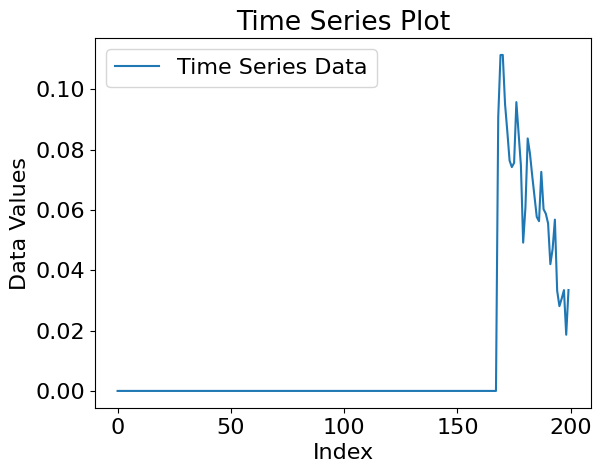

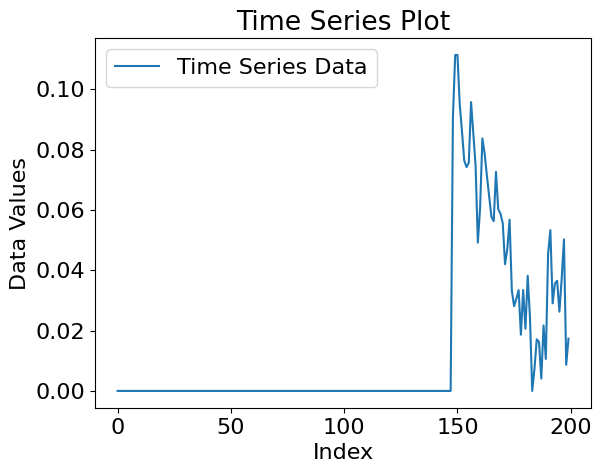

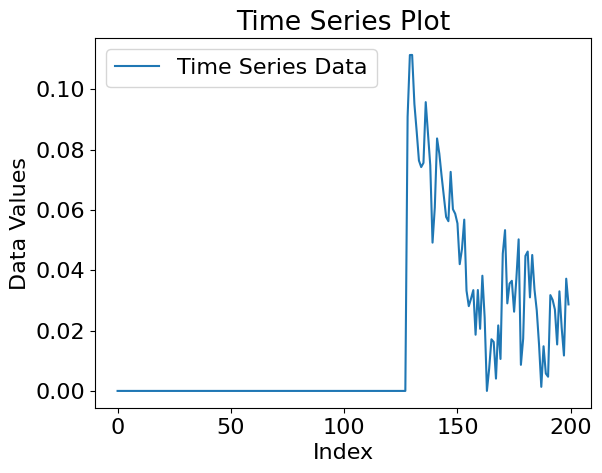

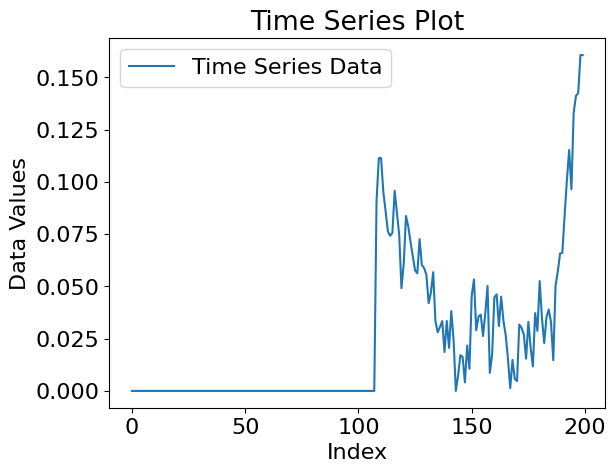

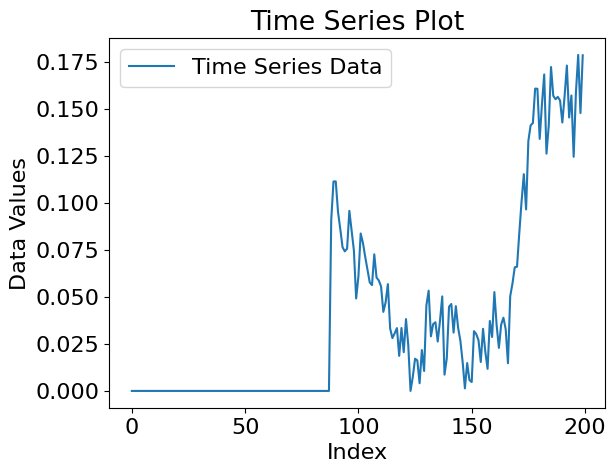

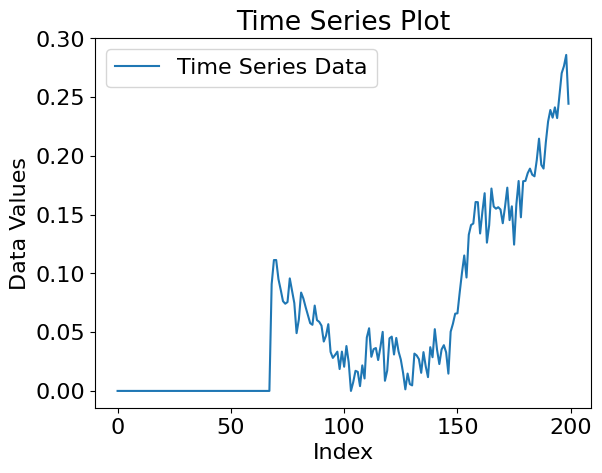

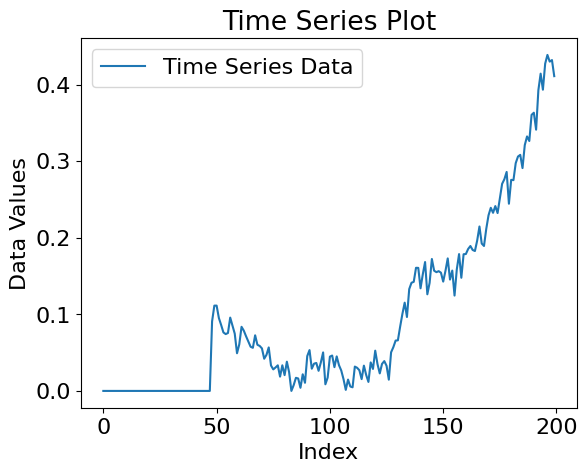

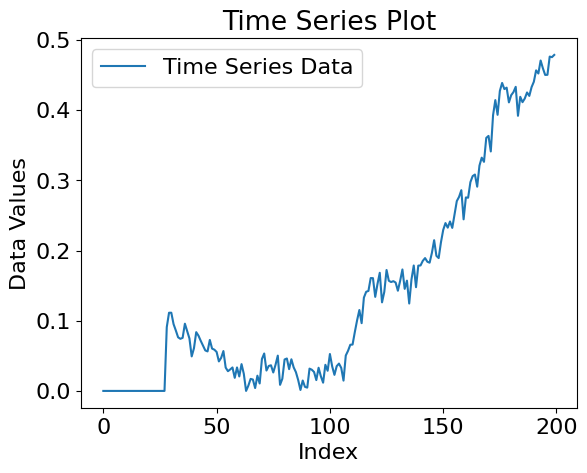

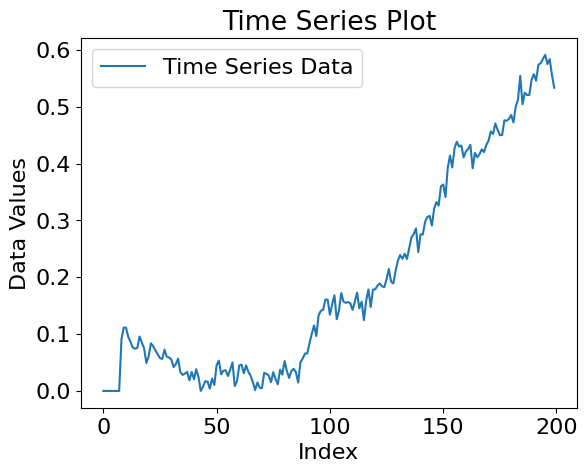

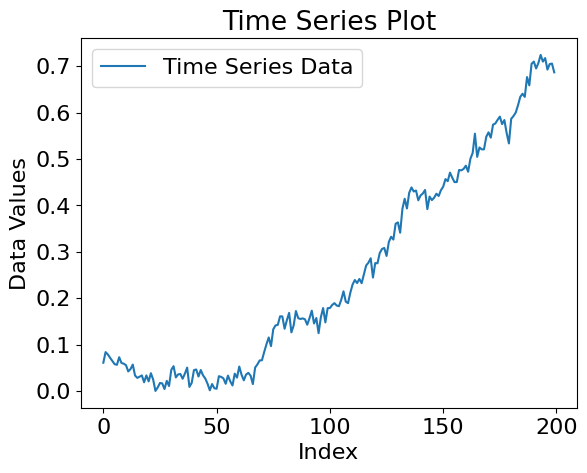

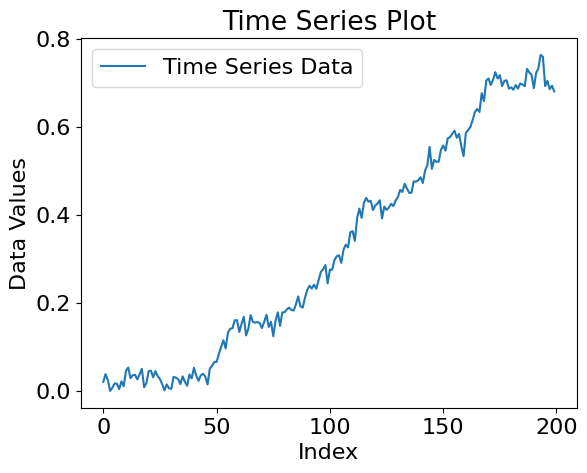

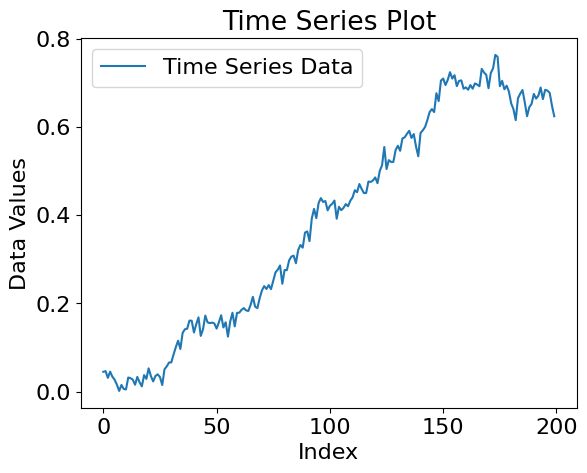

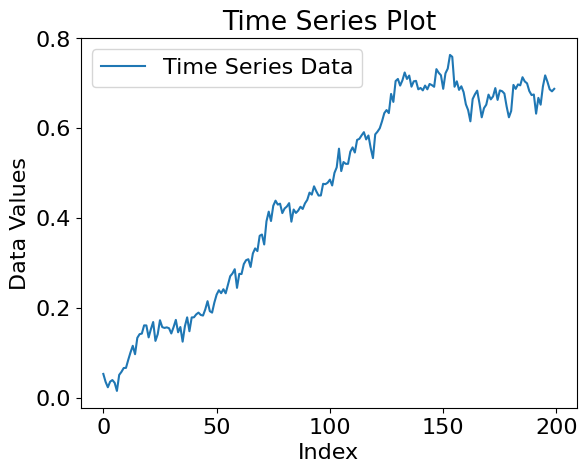

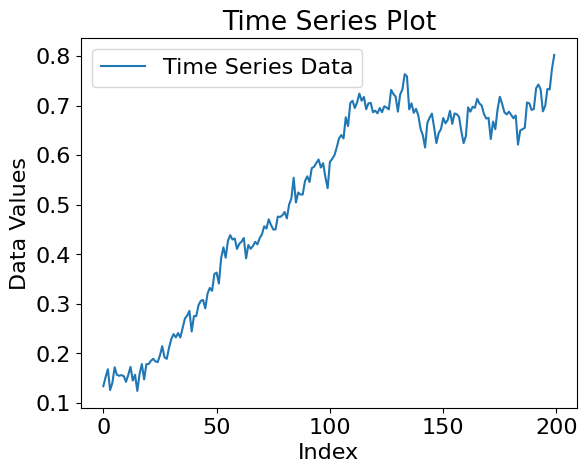

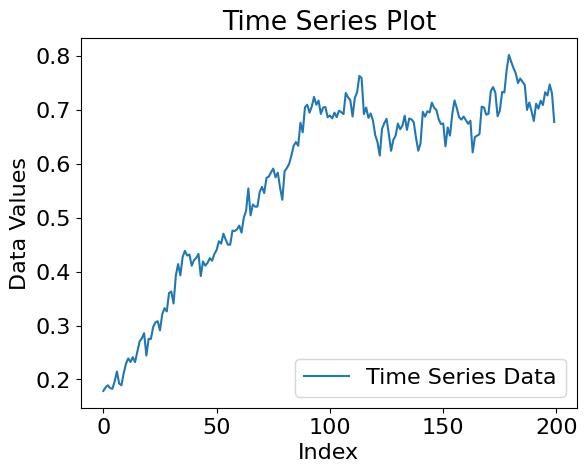

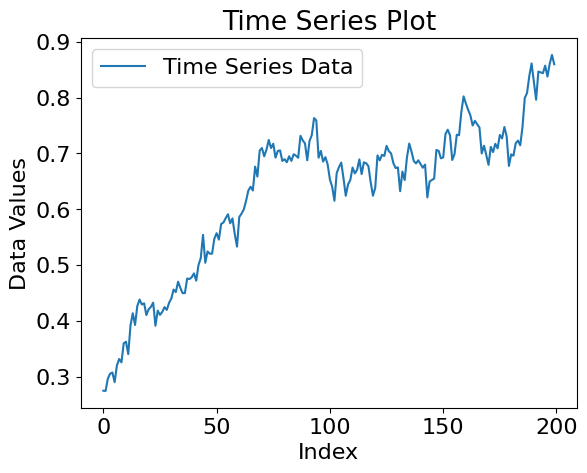

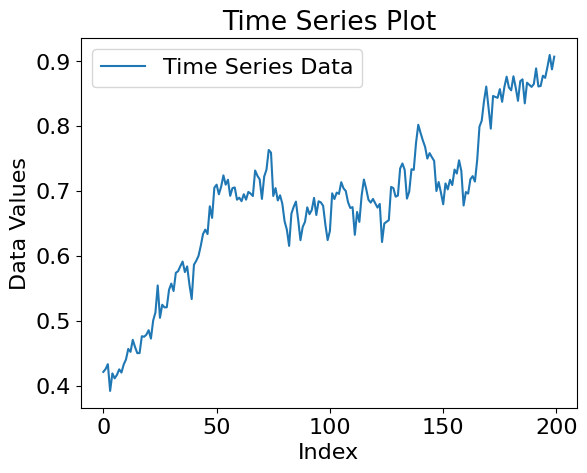

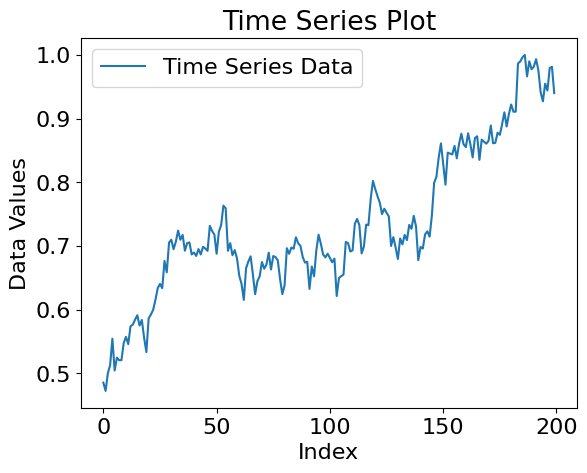

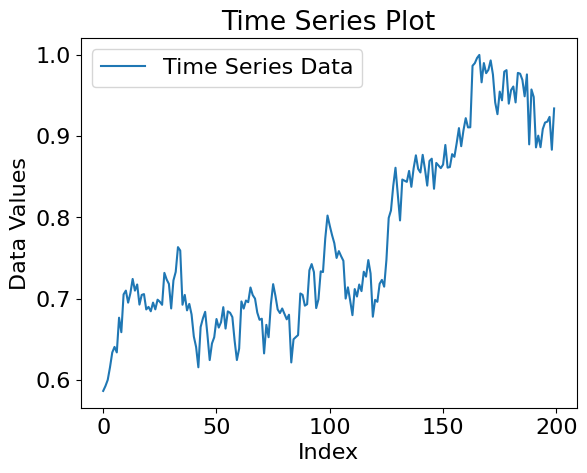

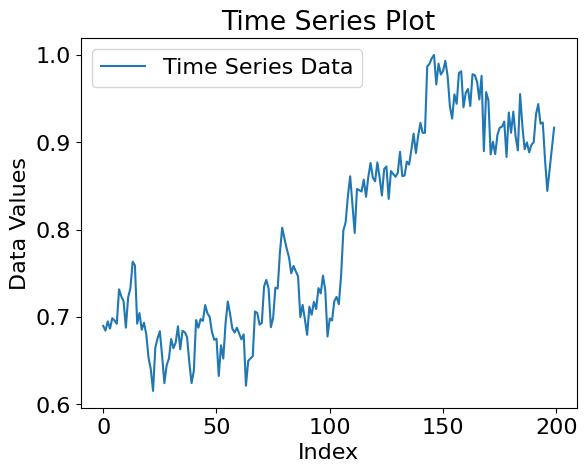

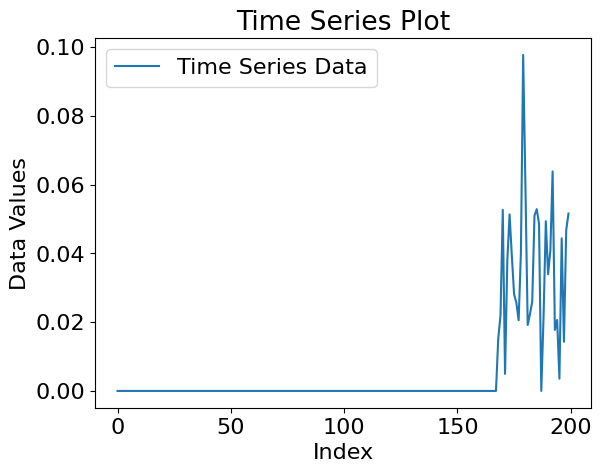

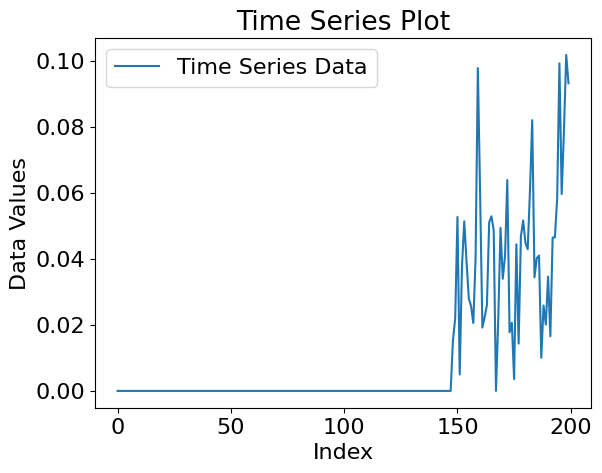

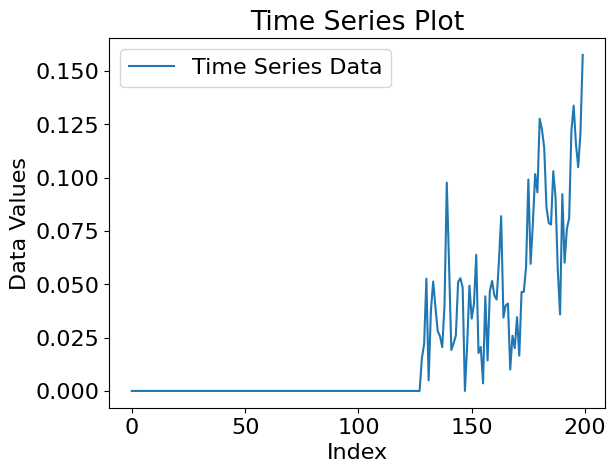

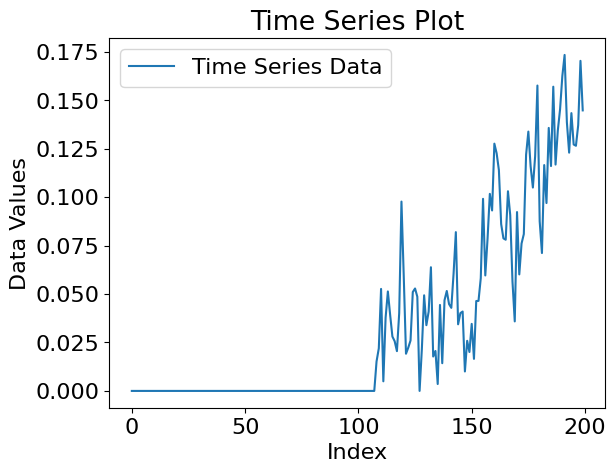

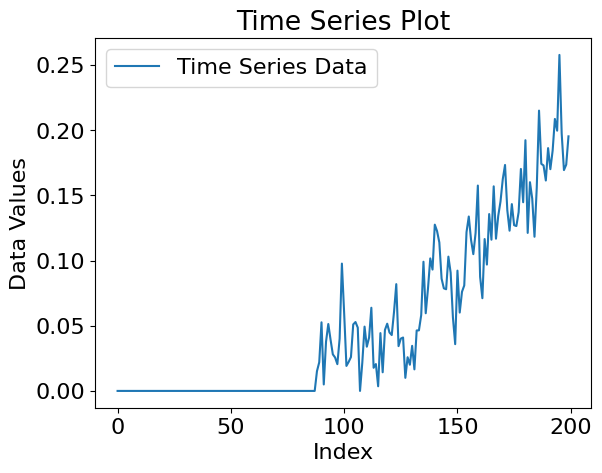

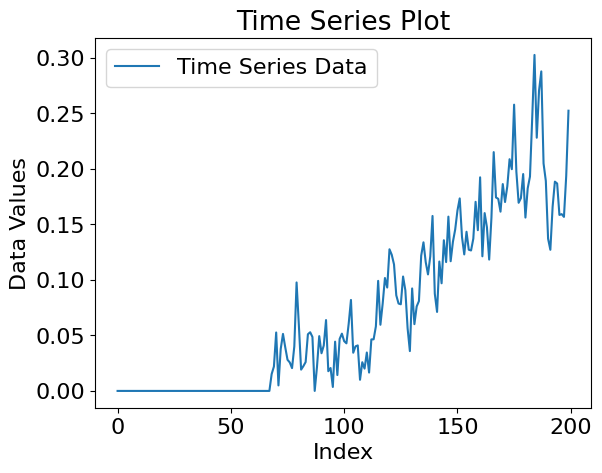

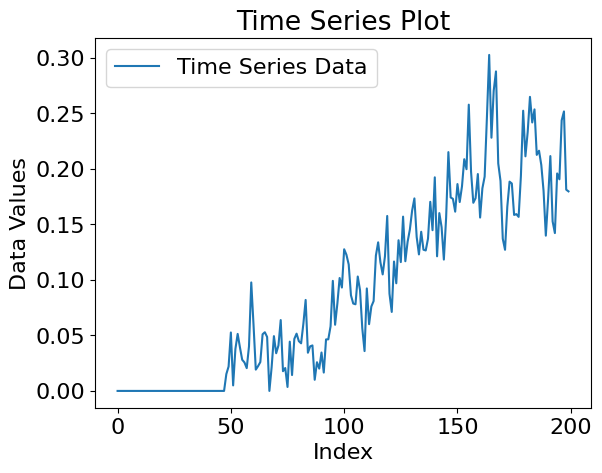

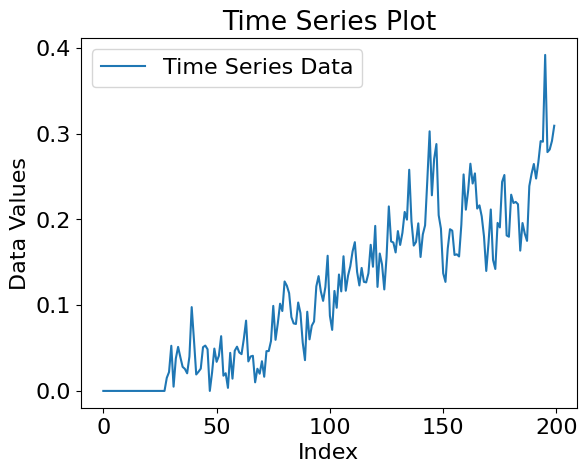

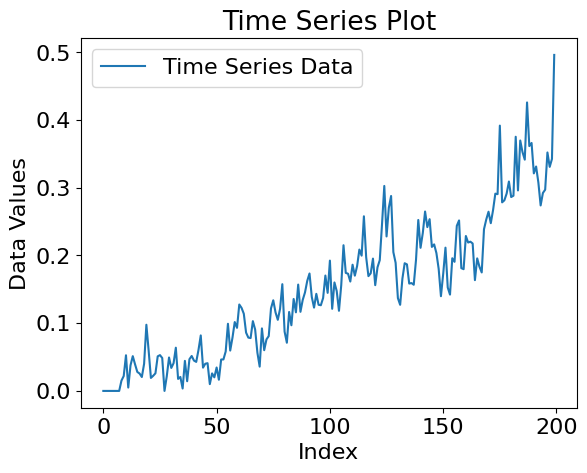

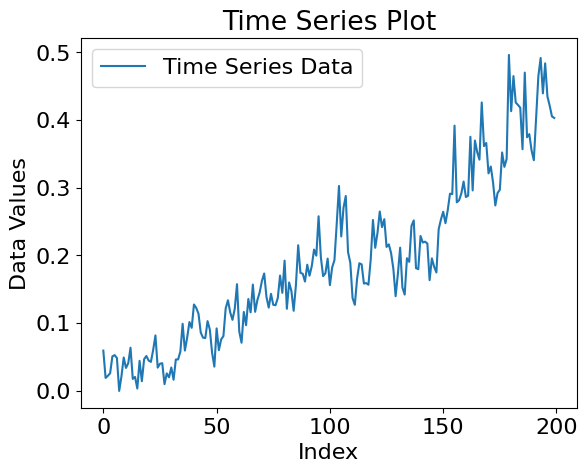

In [ ]:
stop = 0
for i, sequence in enumerate(X_train):
    plt.plot(X_train[i], label='Time Series Data')
    plt.title('Time Series Plot')
    plt.xlabel('Index')
    plt.ylabel('Data Values')
    plt.legend()
    plt.show()

    stop += 1
    if(stop==30): break

# Build the model

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 512
epochs = 200

input_shape, output_shape

((200, 1), (18,))

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(64, 3, padding='same', activation='relu', name='conv')(input_layer)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv_1')(x)

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, name='lstm'), name='bidirectional_lstm')(x)

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True, name='lstm'), name='bidirectional_lstm_2')(x)

    # Add a final Convolution layer to match the desired output shape
    cropped_layer = tfkl.Conv1D(1, 3, padding='same', name='cropped_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = 182

    # Crop the output to the desired length
    cropped_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(cropped_layer)

    output_layer = tfkl.Flatten()(cropped_layer)

    # Construct the model by connecting input and output layers
    modelA = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    modelA.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(epsilon=1e-07))

    return modelA

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 conv (Conv1D)               (None, 200, 64)           256       
                                                                 
 conv_1 (Conv1D)             (None, 200, 128)          24704     
                                                                 
 bidirectional_lstm (Bidire  (None, 200, 256)          263168    
 ctional)                                                        
                                                                 
 bidirectional_lstm_2 (Bidi  (None, 200, 256)          394240    
 rectional)                                                      
                                                                 
 cropped_layer (Conv1D)      (None, 200, 1)        

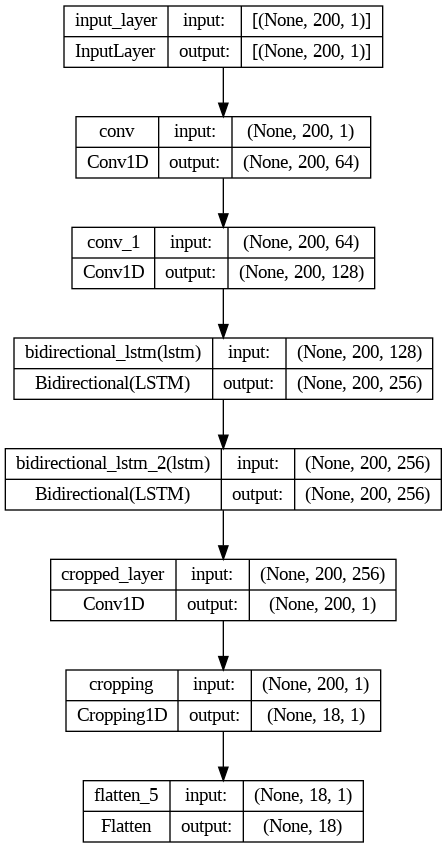

In [ ]:
modelA = build_CONV_LSTM_model(input_shape, output_shape)
modelA.summary()
tfk.utils.plot_model(modelA, expand_nested=True, show_shapes=True)

# Run the model

In [ ]:
# Train the model
history = modelA.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data= (X_val,y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/200
327/327 [==============================] - 71s 217ms/step - loss: 0.0555 - val_loss: 0.0560 - lr: 0.0010
Epoch 2/200
327/327 [==============================] - 66s 202ms/step - loss: 0.0553 - val_loss: 0.0345 - lr: 0.0010
Epoch 3/200
327/327 [==============================] - 66s 201ms/step - loss: 0.0258 - val_loss: 0.0127 - lr: 0.0010
Epoch 4/200
327/327 [==============================] - 66s 201ms/step - loss: 0.0119 - val_loss: 0.0118 - lr: 0.0010
Epoch 5/200
327/327 [==============================] - 66s 202ms/step - loss: 0.0118 - val_loss: 0.0120 - lr: 0.0010
Epoch 6/200
327/327 [==============================] - 66s 201ms/step - loss: 0.0115 - val_loss: 0.0114 - lr: 0.0010
Epoch 7/200
327/327 [==============================] - 66s 202ms/step - loss: 0.0113 - val_loss: 0.0120 - lr: 0.0010
Epoch 8/200
327/327 [==============================] - 66s 201ms/step - loss: 0.0111 - val_loss: 0.0113 - lr: 0.0010
Epoch 9/200
327/327 [==============================] - 66s 202ms

# Post running

Save the model:

In [ ]:
modelA.save('models/category A model')
del modelA

In [ ]:
model = tfk.models.load_model('models/category A model')

Plot training and validation loss over time:

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()